#  1) The Data

### import packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

### import scraped data

In [2]:
forum = pd.read_csv("forum.csv")
forum.drop_duplicates(inplace=True)
forum.shape

(251125, 8)

### text data pre-processing

In [3]:
forum['postDateTime'] = forum['postDateTime'].str.strip()


In [4]:
# create function to filter out rows with non-standard datetime format

def filterBasedOnText(df, feature, ListOfText):
    for text in ListOfText:
        textFilter = df[feature].str.contains(text)
        df = df[~textFilter]
    return df

In [5]:
nonStandardDateTimeList = ['minutes ago', 'Yesterday', 'Today']

forum = filterBasedOnText(forum, 'postDateTime', nonStandardDateTimeList)

In [6]:
forum.shape

(250730, 8)

In [7]:
# keep only posts from Jan 1, 2016 onwards

forum['postDateTime'] = pd.to_datetime(forum['postDateTime'], format='%d %b %Y, %I:%M %p')
forum = forum[forum['postDateTime'] >= pd.datetime(2016, 1, 1)]

In [8]:
#clean userPolitics field
forum['userPolitics'] = forum['userPolitics'].replace("<bound method SelectorList.extract of \[<Selector xpath='div\[3\]\/div\[2\]\/a\[2\]\/text\(\)' data='",'', regex=True)

forum['userPolitics'] = forum['userPolitics'].str.extract(r"data=' (\w+)\\n")

In [9]:
#categorize political ideology with 'sLeftRight'
forum['sLeftRight'] = ''

forum.loc[forum['userPolitics'].isin(['Conservative','Republican','Libertarian','Capitalist']), 'sLeftRight'] = 'Conservative'

forum.loc[forum['userPolitics'].isin(['Liberal','Progressive','Socialist','Democratic','Anarchist','Green']), 'sLeftRight'] = 'Liberal' 

forum.head()

,postDateTime,postText,threadReplies,threadTitle,userMoney,userName,userPolitics,userPosts,sLeftRight
15,2016-01-02 18:24:00,\n\n \n ...,5 replies to this topic,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,"16,928",
16,2016-01-02 18:49:00,\n\n \n ...,5 replies to this topic,Do you think Trump will ever mention the horri...,"7,036.96",TotallyRad,Liberal,"9,903",Liberal
17,2016-01-02 19:48:00,\n\n \n ...,5 replies to this topic,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,"16,928",
18,2016-01-02 20:29:00,\n\n \n ...,5 replies to this topic,Do you think Trump will ever mention the horri...,"7,036.96",TotallyRad,Liberal,"9,903",Liberal
19,2016-01-02 22:23:00,\n\n \n ...,5 replies to this topic,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,"16,928",


In [10]:
#clean post text data
forum['postText'] = forum['postText'].str.strip()
forum['postText'] = forum['postText'].replace('\n','', regex=True)
forum['postText'] = forum['postText'].replace('^,','', regex=True)
forum['postText'] = forum['postText'].str.strip()
forum['postText'] = forum['postText'].replace('^,','', regex=True)
forum['postText'] = forum['postText'].replace('^\s+','', regex=True)

In [11]:
forum['postText'] = forum['postText'].str.replace(r"[\.\,\?\!\<\>\=\+\-\{\}\[\]\"\']",'')

# 1A) limit number of Posts per User

### isolate text and output columns for modeling

In [12]:
# isolate only text and output label in new df: forum_model
forum_model = forum[['userName','postText','sLeftRight']]
forum_model = forum_model[(forum_model['sLeftRight'] == 'Conservative') | (forum_model['sLeftRight'] == 'Liberal')]

# convert classes to binary for later perfomance measure operations
forum_model['sLeftRight'] = np.where(forum_model['sLeftRight'] == 'Conservative', 0, 1)


In [13]:
forum_model['sLeftRight'].value_counts()

0    98160
1    15139
Name: sLeftRight, dtype: int64

In [14]:
userPosts_df = forum_model.groupby(["sLeftRight","userName"]).agg({"postText":"count"})

In [15]:
userPosts_df20 = userPosts_df.sort_values(by=["postText"],ascending=False).head(20)

In [16]:
userPosts_df20 = userPosts_df20.reset_index()

In [17]:
userPosts_df20

,sLeftRight,userName,postText
0,0,roadkill,30628
1,0,Bigsky,13349
2,0,Str8tEdge,8537
3,0,crimsongulf,8488
4,0,Termin8tor,8408
5,0,golfboy,5356
6,0,Sgt Bilko,5302
7,0,NeoConvict,4828
8,1,onlyaladd,3410
9,1,Henry_,2423


In [18]:
custom_palette = []

for index, row in userPosts_df20.iterrows():
    if row['sLeftRight'] == 0:
        custom_palette.append('indianred')
    else:
        custom_palette.append('royalblue')

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


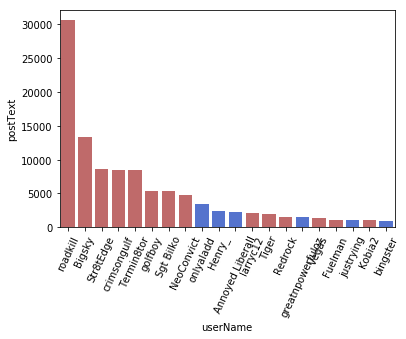

In [19]:
userPosts_df20_barplot = sns.barplot(x="userName", y='postText', data=userPosts_df20,palette=custom_palette)

for item in userPosts_df20_barplot.get_xticklabels():
    item.set_rotation(65)

In [20]:
avgPost_perIdeology = userPosts_df.groupby(["sLeftRight"]).agg({"postText":"mean"})

In [21]:
avgPost_perIdeology = avgPost_perIdeology.reset_index()

In [22]:
avgPost_perIdeology['sLeftRight'] = np.where(avgPost_perIdeology['sLeftRight'] == 0, "Conservative", "Liberal")

In [23]:
avgPost_perIdeology

,sLeftRight,postText
0,Conservative,1924.705882
1,Liberal,296.843137


/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(0, 2000)

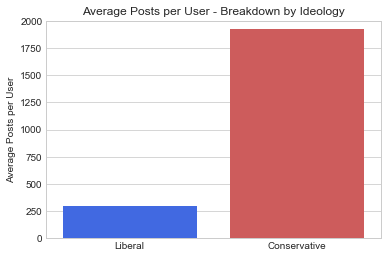

In [24]:
sns.set_style('whitegrid')
sns.barplot(x=avgPost_perIdeology['sLeftRight'],
            y=avgPost_perIdeology['postText'],
            palette = ['royalblue','indianred'], order=["Liberal","Conservative"], saturation=1)


plt.title('Average Posts per User - Breakdown by Ideology')
plt.xlabel('')
plt.ylabel('Average Posts per User')

plt.ylim((0,2000))

In [25]:
# randomly select posts from convservative user such that no conservative user has more posts than the top liberal use


In [26]:
topUserPosts_df = userPosts_df.sort_values(by=['sLeftRight',"postText"],ascending=False)

In [27]:
topLiberalPost = topUserPosts_df.head(1)['postText'][0]

In [28]:
topLiberalPost

3410

In [29]:
userPosts_df = userPosts_df.reset_index()

In [30]:
userPosts_df.head()

,sLeftRight,userName,postText
0,0,123SMARTERTHANYOU,2
1,0,AnonymousExposer,1
2,0,Balance,2
3,0,Bigsky,13349
4,0,Donald Trump,14


In [31]:
topConservativePosters = list(userPosts_df[(userPosts_df['sLeftRight'] == 0) & (userPosts_df['postText'] > topLiberalPost)]['userName'])

In [32]:
topConservativePosters

['Bigsky',
 'NeoConvict',
 'Sgt Bilko',
 'Str8tEdge',
 'Termin8tor',
 'crimsongulf',
 'golfboy',
 'roadkill']

In [33]:
forum_dontSample = forum_model[~forum_model["userName"].isin(topConservativePosters)]

In [34]:
forum_dontSample['sLeftRight'].value_counts()

1    15139
0    13264
Name: sLeftRight, dtype: int64

In [35]:
for poster in topConservativePosters:
    forumPoster_sample = forum_model[forum_model['userName'] == poster].sample(n=topLiberalPost)
    forum_dontSample = forum_dontSample.append(forumPoster_sample, ignore_index=True)

In [36]:
forum_dontSample['sLeftRight'].value_counts()

0    40544
1    15139
Name: sLeftRight, dtype: int64

In [37]:
forum_model = forum_dontSample

In [38]:
userPosts_df = forum_model.groupby(["sLeftRight","userName"]).agg({"postText":"count"})

In [39]:
avgPost_perIdeology = userPosts_df.groupby(["sLeftRight"]).agg({"postText":"mean"})

In [40]:
avgPost_perIdeology = avgPost_perIdeology.reset_index()

In [41]:
avgPost_perIdeology['sLeftRight'] = np.where(avgPost_perIdeology['sLeftRight'] == 0, "Conservative", "Liberal")

In [42]:
avgPost_perIdeology

,sLeftRight,postText
0,Conservative,794.980392
1,Liberal,296.843137


In [43]:
userPosts_df = forum_model.groupby(["sLeftRight","userName"]).agg({"postText":"count"})

In [44]:
userPosts_df20 = userPosts_df.sort_values(by=["postText"],ascending=False).head(20)

In [45]:
userPosts_df20 = userPosts_df20.reset_index()

In [46]:
userPosts_df20

,sLeftRight,userName,postText
0,0,Str8tEdge,3410
1,0,NeoConvict,3410
2,0,Bigsky,3410
3,0,golfboy,3410
4,0,crimsongulf,3410
5,1,onlyaladd,3410
6,0,Termin8tor,3410
7,0,roadkill,3410
8,0,Sgt Bilko,3410
9,1,Henry_,2423


/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(0, 32000)

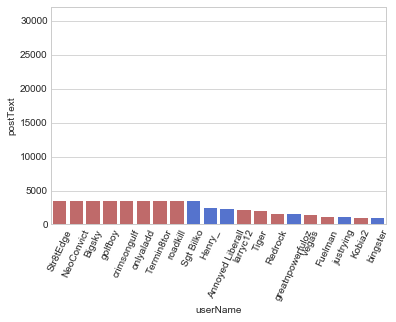

In [47]:
userPosts_df20_barplot = sns.barplot(x="userName", y='postText', data=userPosts_df20,palette=custom_palette)

for item in userPosts_df20_barplot.get_xticklabels():
    item.set_rotation(65)
    
plt.ylim((0,32000))

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(0, 2000)

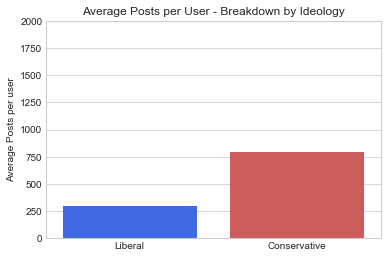

In [48]:
sns.set_style('whitegrid')
sns.barplot(x=avgPost_perIdeology['sLeftRight'],
            y=avgPost_perIdeology['postText'],
            palette = ['royalblue','indianred'], order=["Liberal","Conservative"], saturation=1)


plt.title('Average Posts per User - Breakdown by Ideology')
plt.xlabel('')
plt.ylabel('Average Posts per user')
plt.ylim((0,2000))


# 2) Building a Baseline

In [49]:
forum_model['sLeftRight'].value_counts()

0    40544
1    15139
Name: sLeftRight, dtype: int64

### train test split

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(forum_model['postText'], 
                                                    forum_model['sLeftRight'], 
                                                    stratify=forum_model['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [51]:
y_train.value_counts()

0    27164
1    10143
Name: sLeftRight, dtype: int64

In [52]:
y_test.value_counts()

0    13380
1     4996
Name: sLeftRight, dtype: int64

### buildinng a pipeline with CountVectorizer() and TfdifTransformer() & baseline models

In [53]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [55]:
# create model pipelines
text_mnb = Pipeline([('vect',CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB())])

text_logr = Pipeline([('vect',CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression())])

In [56]:
# fit models
text_mnb = text_mnb.fit(X_train, y_train)

text_logr = text_logr.fit(X_train, y_train)

In [57]:
### evaluate with cross_val_score accuracy
from sklearn.model_selection import cross_val_score

In [58]:
cross_val_score(text_mnb, X_train, y_train, cv=3, scoring="accuracy")

array([0.73657124, 0.7362496 , 0.73590671])

In [59]:
cross_val_score(text_logr, X_train, y_train, cv=3, scoring="accuracy")

array([0.76913799, 0.76656481, 0.76622437])

In [60]:
### evaluate with confusion matrix
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score

In [61]:
matrixValues = {"Predict: 0" : ["TN","FN"],"Predict: 1":["FP","TP"]}
confusionMatrix = pd.DataFrame(matrixValues,index=["Actual: 0", "Actual: 1"])
confusionMatrix

,Predict: 0,Predict: 1
Actual: 0,TN,FP
Actual: 1,FN,TP


In [62]:
from sklearn.model_selection import cross_val_predict

In [63]:
y_train_pred_mnb = cross_val_predict(text_mnb, X_train, y_train, cv=3)

y_train_pred_logr = cross_val_predict(text_logr, X_train, y_train, cv=3)

In [64]:
confusion_matrix(y_train, y_train_pred_mnb)

array([[27141,    23],
       [ 9817,   326]])

In [65]:
confusion_matrix(y_train,y_train_pred_logr)

array([[26244,   920],
       [ 7761,  2382]])

In [66]:
def accuracy_precision_recall_F1(y_train_data,y_train_pred):
    print("Accuracy Score = " + str(round(accuracy_score(y_train_data, y_train_pred),5)))
    print("Precision Score = " + str(round(precision_score(y_train_data, y_train_pred),5)))
    print("Recall Score = " + str(round(recall_score(y_train_data, y_train_pred),5)))
    print("F1 Score = " + str(round(f1_score(y_train_data, y_train_pred),5)))

In [67]:
accuracy_precision_recall_F1(y_train, y_train_pred_mnb)

Accuracy Score = 0.73624
Precision Score = 0.9341
Recall Score = 0.03214
F1 Score = 0.06214


In [68]:
accuracy_precision_recall_F1(y_train, y_train_pred_logr)

Accuracy Score = 0.76731
Precision Score = 0.72138
Recall Score = 0.23484
F1 Score = 0.35433


### even though high scores, confusion matrix shows extremely high False Positive Rate... labeling liberals as conservatives... need to balance class weights to fix

# rerun models balancing by class

In [69]:
y_train.value_counts()

0    27164
1    10143
Name: sLeftRight, dtype: int64

In [70]:
classPrior0 = y_train.value_counts()[0]/y_train.shape[0]

classPrior1 = 1 - classPrior0

In [71]:
print(round(classPrior0,3))
print(round(classPrior1,3))

0.728
0.272


In [72]:
# create model pipelines
text_mnb = Pipeline([('vect',CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB(class_prior=(classPrior1,classPrior0)))])

text_logr = Pipeline([('vect',CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

In [73]:
# fit models
text_mnb = text_mnb.fit(X_train, y_train)

text_logr = text_logr.fit(X_train, y_train)

In [74]:
y_train_pred_mnb = cross_val_predict(text_mnb, X_train, y_train, cv=3)

y_train_pred_logr = cross_val_predict(text_logr, X_train, y_train, cv=3)

In [75]:
confusion_matrix(y_train, y_train_pred_mnb)

array([[17314,  9850],
       [ 4645,  5498]])

In [76]:
confusion_matrix(y_train, y_train_pred_logr)

array([[20565,  6599],
       [ 3659,  6484]])

In [77]:
accuracy_precision_recall_F1(y_train, y_train_pred_mnb)

Accuracy Score = 0.61147
Precision Score = 0.35822
Recall Score = 0.54205
F1 Score = 0.43137


In [78]:
accuracy_precision_recall_F1(y_train, y_train_pred_logr)

Accuracy Score = 0.72504
Precision Score = 0.4956
Recall Score = 0.63926
F1 Score = 0.55834


In [79]:
y_scores_mnb = cross_val_predict(text_mnb,
                                 X_train,
                                 y_train,
                                 cv=3,
                                 method="predict_proba")
y_scores_mnb = y_scores_mnb[:, 1]

In [80]:
y_scores_logr = cross_val_predict(text_logr,
                                  X_train,
                                  y_train,
                                  cv=3,
                                  method="decision_function")

In [81]:
# plot precision/recall curve for both

In [82]:
from sklearn.metrics import precision_recall_curve

In [83]:
precision_mnb, recall_mnb, threshold_mnb = precision_recall_curve(y_train,
                                                                  y_scores_mnb)

precision_logr, recall_logr, threshold_logr = precision_recall_curve(y_train,
                                                                     y_scores_logr)

(0, 1)

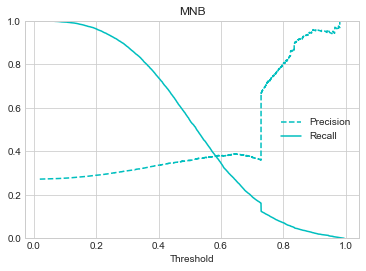

In [84]:
plt.plot(threshold_mnb,precision_mnb[:-1],color="c",linestyle="--",label="Precision")
plt.plot(threshold_mnb,recall_mnb[:-1],color="c",label="Recall")

plt.title("MNB")
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.ylim([0,1])

(0, 1)

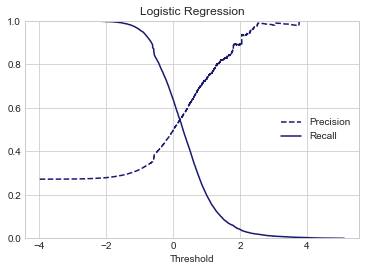

In [85]:
plt.plot(threshold_logr,precision_logr[:-1],color="midnightblue",linestyle="--",label="Precision")
plt.plot(threshold_logr,recall_logr[:-1],color="midnightblue",label="Recall")

plt.title("Logistic Regression")
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.ylim([0,1])

In [86]:
# plot precision vs recall curve of both

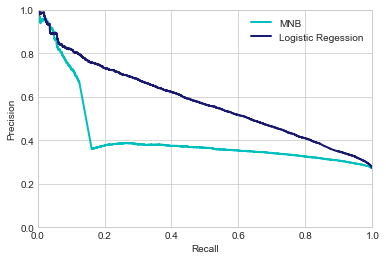

In [87]:
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot(recall_mnb,precision_mnb,"c",linewidth=2,label="MNB")
plt.plot(recall_logr,precision_logr,color="midnightblue",linewidth=2,label="Logistic Regession")

plt.legend(loc="upper right")
plt.show()

In [88]:
# plot ROC curves for both

In [89]:
from sklearn.metrics import roc_curve

In [90]:
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(y_train, y_scores_mnb)

In [91]:
fpr_logr, tpr_logr, thresholds_logr = roc_curve(y_train, y_scores_logr)

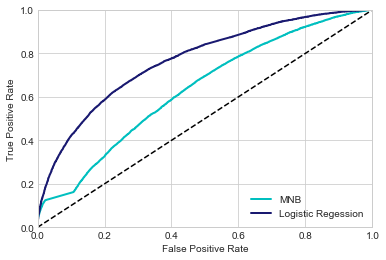

In [92]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_mnb,tpr_mnb,color="c",linewidth=2,label="MNB")
plt.plot(fpr_logr,tpr_logr,color="midnightblue",linewidth=2,label="Logistic Regession")

plt.legend(loc="lower right")
plt.show()

In [93]:
from sklearn.metrics import roc_auc_score

In [94]:
print("MNB AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_mnb),5)))

print("Logistic Regression AUC = "+str(round(roc_auc_score(y_train,
                                                           y_train_pred_logr),5)))

MNB AUC = 0.58972
Logistic Regression AUC = 0.69816


# stopwords and stemming

In [95]:
import nltk

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [96]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [97]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [98]:
# create model pipelines
text_mnb = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB(class_prior=(classPrior1,classPrior0)))])

text_logr = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

In [99]:
# fit models
text_mnb = text_mnb.fit(X_train, y_train)

text_logr = text_logr.fit(X_train, y_train)

In [100]:
y_train_pred_mnb = cross_val_predict(text_mnb, X_train, y_train, cv=3)

y_train_pred_logr = cross_val_predict(text_logr, X_train, y_train, cv=3)

In [101]:
confusion_matrix(y_train, y_train_pred_mnb)

array([[14496, 12668],
       [ 2949,  7194]])

In [102]:
confusion_matrix(y_train,y_train_pred_logr)

array([[20518,  6646],
       [ 3694,  6449]])

In [103]:
accuracy_precision_recall_F1(y_train, y_train_pred_mnb)

Accuracy Score = 0.58139
Precision Score = 0.3622
Recall Score = 0.70926
F1 Score = 0.47952


In [104]:
accuracy_precision_recall_F1(y_train, y_train_pred_logr)

Accuracy Score = 0.72284
Precision Score = 0.49248
Recall Score = 0.63581
F1 Score = 0.55504


In [105]:
y_scores_mnb_swr = cross_val_predict(text_mnb,
                                 X_train,
                                 y_train,
                                 cv=3,
                                 method="predict_proba")

y_scores_mnb_swr = y_scores_mnb_swr[:, 1]

In [106]:
y_scores_logr_swr = cross_val_predict(text_logr,
                                  X_train,
                                  y_train,
                                  cv=3,
                                  method="decision_function")

In [107]:
precision_mnb_swr, recall_mnb_swr, threshold_mnb_swr = precision_recall_curve(y_train,
                                                                  y_scores_mnb_swr)

precision_logr_swr, recall_logr_swr, threshold_logr_swr = precision_recall_curve(y_train,
                                                                     y_scores_logr_swr)

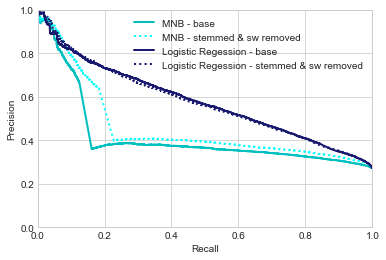

In [108]:
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot(recall_mnb,
         precision_mnb,
         color="c",
         linewidth=2,
         label="MNB - base")

plt.plot(recall_mnb_swr,
         precision_mnb_swr,
         color="cyan",
         linestyle=":",
         linewidth=2,
         label="MNB - stemmed & sw removed")

plt.plot(recall_logr,
         precision_logr,
         color="midnightblue",
         linewidth=2,
         label="Logistic Regession - base")

plt.plot(recall_logr_swr,
         precision_logr_swr,
         color="midnightblue",
         linestyle=":",
         linewidth=2,
         label="Logistic Regession - stemmed & sw removed")


plt.legend(loc="upper right")
plt.show()

In [109]:
fpr_mnb_swr, tpr_mnb_swr, thresholds_mnb_swr = roc_curve(y_train, y_scores_mnb_swr)

In [110]:
fpr_logr_swr, tpr_logr_swr, thresholds_logr_swr = roc_curve(y_train, y_scores_logr_swr)

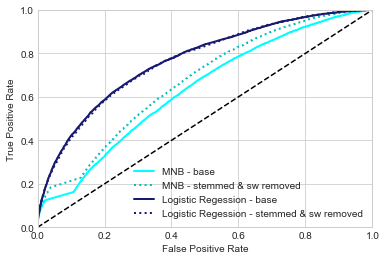

In [111]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_mnb,tpr_mnb,color="cyan",
         linewidth=2,
         label="MNB - base")

plt.plot(fpr_mnb_swr,
         tpr_mnb_swr,
         color="c",
         linestyle=":",
         linewidth=2,
         label="MNB - stemmed & sw removed")

plt.plot(fpr_logr,
         tpr_logr,
         color="midnightblue",
         linewidth=2,
         label="Logistic Regession - base")

plt.plot(fpr_logr_swr,
         tpr_logr_swr,
         color="midnightblue",
         linestyle=":",
         linewidth=2,
         label="Logistic Regession - stemmed & sw removed")

plt.legend(loc="lower right")
plt.show()

In [112]:
print("MNB AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_mnb),5)))

print("Logistic Regression AUC = "+str(round(roc_auc_score(y_train,
                                                           y_train_pred_logr),5)))

MNB AUC = 0.62145
Logistic Regression AUC = 0.69557


# run additional models with stemming and stopwords removed:

### randomForest

In [113]:
from sklearn.ensemble import RandomForestClassifier


text_rf = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier(class_weight="balanced"))])

In [114]:
text_rf = text_rf.fit(X_train, y_train)

In [115]:
y_train_pred_rf = cross_val_predict(text_rf, X_train, y_train, cv=3)

In [116]:
confusion_matrix(y_train, y_train_pred_rf)

array([[25721,  1443],
       [ 7651,  2492]])

In [117]:
accuracy_precision_recall_F1(y_train, y_train_pred_rf)

Accuracy Score = 0.75624
Precision Score = 0.63329
Recall Score = 0.24569
F1 Score = 0.35403


In [118]:
y_scores_rf = cross_val_predict(text_rf, X_train, 
                                y_train, cv=3,
                                method="predict_proba")
y_scores_rf = y_scores_rf[:, 1]

In [119]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

In [120]:
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train,
                                                                  y_scores_rf)

In [121]:
print("RF AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_rf),5)))

RF AUC = 0.59628


### randomForest -  get feature importances

In [122]:
rf_feature_names = text_rf.steps[0][1].get_feature_names()

In [123]:
rf_feature_scores = text_rf.steps[2][1].feature_importances_

In [124]:
rf_features = pd.DataFrame(rf_feature_scores,rf_feature_names).reset_index()

In [125]:
rf_features.columns.values[0] = 'feature'
rf_features.columns.values[1] = 'score'
rf_features = rf_features.reset_index(drop=True)

In [126]:
rf_features_top25 = rf_features.sort_values(by="score",ascending=False).reset_index(drop=True).head(25)

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


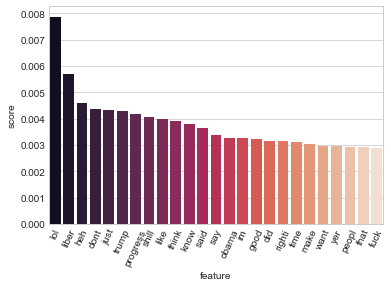

In [127]:
rf_features_top25 = sns.barplot(x='feature',
            y='score',
            data = rf_features_top25,
            palette="rocket")

for item in rf_features_top25.get_xticklabels():
    item.set_rotation(65)

### Support Vector Classifier - Linear

In [128]:
from sklearn.svm import LinearSVC

In [129]:
text_svc = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('svc', LinearSVC(loss='hinge', 
                                      class_weight="balanced"))])

In [130]:
text_svc = text_svc.fit(X_train, y_train)

In [131]:
y_train_pred_svc = cross_val_predict(text_svc, X_train, y_train, cv=3)

In [132]:
confusion_matrix(y_train, y_train_pred_svc)

array([[20734,  6430],
       [ 3847,  6296]])

In [133]:
accuracy_precision_recall_F1(y_train, y_train_pred_svc)

Accuracy Score = 0.72453
Precision Score = 0.49474
Recall Score = 0.62072
F1 Score = 0.55061


In [134]:
y_scores_svc = cross_val_predict(text_svc, X_train, y_train, cv=3, method="decision_function")

In [135]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_scores_svc)

In [136]:
precision_svc, recall_svc, threshold_svc = precision_recall_curve(y_train,
                                                                  y_scores_svc)

In [137]:
print("SVC AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_svc),5)))

SVC AUC = 0.69201


### Look at all outputs

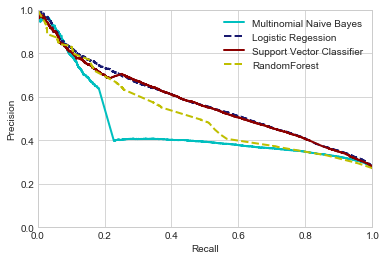

In [139]:
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot(recall_mnb_swr,precision_mnb_swr,
         "c",
         linewidth=2,
         label="Multinomial Naive Bayes")

plt.plot(recall_logr_swr,
         precision_logr_swr,
         color="midnightblue",
         linestyle="--",
         linewidth=2,
         label="Logistic Regession")

plt.plot(recall_svc,
         precision_svc,
         color="darkred",
         linewidth=2,
         label="Support Vector Classifier")

plt.plot(recall_rf,
         precision_rf,
         "y--",linewidth=2,
         label="RandomForest")


plt.legend(loc="upper right")
plt.show()

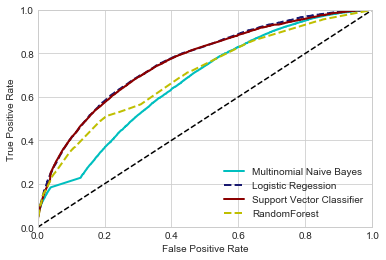

In [140]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_mnb_swr,tpr_mnb_swr,
         "c",
         linewidth=2,
         label="Multinomial Naive Bayes")

plt.plot(fpr_logr_swr,
         tpr_logr_swr,
         color="midnightblue",
         linestyle="--",
         linewidth=2,
         label="Logistic Regession")

plt.plot(fpr_svc,
         tpr_svc,
         color="darkred",
         linewidth=2,
         label="Support Vector Classifier")

plt.plot(fpr_rf,
         tpr_rf,
         "y--",
         linewidth=2,
         label="RandomForest")

plt.legend(loc="lower right")
plt.show()

### SGDClassifier - hinge (SVC) and log (logistic regression)

In [141]:
from sklearn.linear_model import SGDClassifier

#hinge

text_sgd_svc = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('sgd', SGDClassifier(
                                      class_weight="balanced",
                                      loss ="hinge"))])
text_sgd_svc = text_sgd_svc.fit(X_train, y_train)

y_train_pred_sgd_svc = cross_val_predict(text_sgd_svc,
                                         X_train,
                                         y_train,
                                         cv=3)


/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureW

In [142]:
### hinge output

In [143]:
confusion_matrix(y_train, y_train_pred_sgd_svc)

array([[20480,  6684],
       [ 3823,  6320]])

In [144]:
accuracy_precision_recall_F1(y_train, y_train_pred_sgd_svc)

Accuracy Score = 0.71836
Precision Score = 0.486
Recall Score = 0.62309
F1 Score = 0.54608


In [145]:
y_scores_sgd_svc = cross_val_predict(text_sgd_svc, X_train, y_train, cv=3, method="decision_function")

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureW

In [146]:
fpr_sgd_svc, tpr_sgd_svc, thresholds_sgd_svc = roc_curve(y_train, y_scores_sgd_svc)

In [147]:
precision_sgd_svc, recall_sgd_svc, threshold_sgd_svc = precision_recall_curve(y_train,
                                                                  y_scores_sgd_svc)

In [148]:
print("SGD AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_sgd_svc),5)))

SGD AUC = 0.68851


In [149]:
### log output

In [150]:
#log

text_sgd_log = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('sgd', SGDClassifier(
                                      class_weight="balanced",
                                      loss ="log"))])
text_sgd_log = text_sgd_log.fit(X_train, y_train)

y_train_pred_sgd_log = cross_val_predict(text_sgd_log, X_train, y_train, cv=3)


/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureW

In [151]:
confusion_matrix(y_train, y_train_pred_sgd_log)

array([[19825,  7339],
       [ 3573,  6570]])

In [152]:
accuracy_precision_recall_F1(y_train, y_train_pred_sgd_log)

Accuracy Score = 0.70751
Precision Score = 0.47236
Recall Score = 0.64774
F1 Score = 0.54632


In [153]:
y_scores_logr = cross_val_predict(text_logr,
                                  X_train,
                                  y_train,
                                  cv=3,
                                  method="decision_function")

In [154]:
y_scores_sgd_log = cross_val_predict(text_sgd_log,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     method="decision_function")

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureW

In [155]:
fpr_sgd_log, tpr_sgd_log, thresholds_sgd_log = roc_curve(y_train, y_scores_sgd_log)

In [156]:
precision_sgd_log, recall_sgd_log, threshold_sgd_log = precision_recall_curve(y_train,
                                                                  y_scores_sgd_log)

In [157]:
print("SGD AUC = "+str(round(roc_auc_score(y_train,
                                           y_train_pred_sgd_log),5)))

SGD AUC = 0.68878


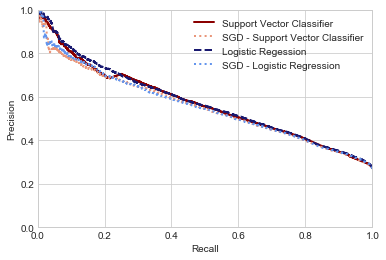

In [158]:
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot(recall_svc,precision_svc,color="darkred",linestyle="-",linewidth=2,label="Support Vector Classifier")
plt.plot(recall_sgd_svc,precision_sgd_svc,color="darksalmon",linestyle=":",linewidth=2,label="SGD - Support Vector Classifier")


plt.plot(recall_logr_swr,precision_logr_swr,color="midnightblue",linestyle="--",linewidth=2,label="Logistic Regession")
plt.plot(recall_sgd_log,precision_sgd_log,color="cornflowerblue",linestyle=":",linewidth=2,label="SGD - Logistic Regression")



plt.legend(loc="upper right")
plt.show()

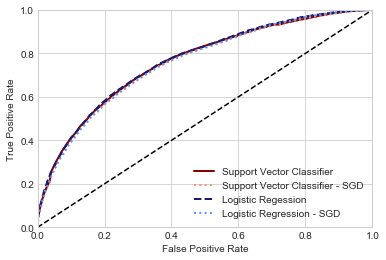

In [159]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


plt.plot(fpr_svc,tpr_svc,color="darkred",linestyle="-",linewidth=2,label="Support Vector Classifier")
plt.plot(fpr_sgd_svc,tpr_sgd_svc,color="darksalmon",linestyle=":",linewidth=2,label="Support Vector Classifier - SGD")

plt.plot(fpr_logr_swr,tpr_logr_swr,color="midnightblue",linestyle="--",linewidth=2,label="Logistic Regession")
plt.plot(fpr_sgd_log,tpr_sgd_log,color="cornflowerblue",linestyle=":",linewidth=2,label="Logistic Regression - SGD")

plt.legend(loc="lower right")
plt.show()

# Tune HyperParameters via Testing F1 Score

In [160]:
hyperParameter_C = [1.3,1.4,1.5,1.6,1.7]
f1_trainList_logr = []
f1_testList_logr = []

for c in hyperParameter_C:
    text_logr = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced",
                                              C = c))])
#fit onto training data and get f1 score
    text_logr = text_logr.fit(X_train,y_train)
    y_pred_logr = text_logr.predict(X_train)
    y_train_f1_score = round(f1_score(y_train, y_pred_logr),5)
    f1_trainList_logr.append(y_train_f1_score)
    
#predict test data f1 score 
    y_test_pred_logr = text_logr.predict(X_test)
    y_test_f1_score = round(f1_score(y_test, y_test_pred_logr),5)
    f1_testList_logr.append(y_test_f1_score)


In [161]:
f1_testList_logr

[0.57534, 0.5761, 0.57705, 0.57665, 0.57583]

In [162]:
f1_trainList_logr

[0.73204, 0.73651, 0.7403, 0.7433, 0.74598]

In [163]:
logr_hyperParameter_C_df = pd.DataFrame({
    'C' : hyperParameter_C,
    'F1 Training Score': f1_trainList_logr,
    'F1 Test Score' : f1_testList_logr
})

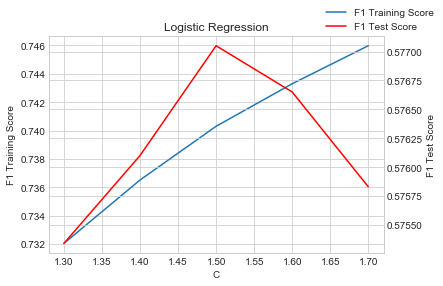

In [164]:
ax = logr_hyperParameter_C_df.plot(x="C", y="F1 Training Score", legend=False)
plt.ylabel("F1 Training Score")
ax2 = ax.twinx()
logr_hyperParameter_C_df.plot(x="C", y="F1 Test Score", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.ylabel("F1 Test Score")
plt.title("Logistic Regression")
plt.show()

In [165]:
hyperParameter_C = [1.3,1.4,1.5,1.6,1.7]
f1_trainList_svc = []
f1_testList_svc = []

for c in hyperParameter_C:
    text_svc = Pipeline([('vect', stemmed_count_vect),
                        ('tfidf', TfidfTransformer()),
                        ('svc', LinearSVC(loss='hinge', 
                                          class_weight="balanced",
                                         C = c))])
    
#fit onto training data and get f1 score
    text_svc = text_svc.fit(X_train,y_train)
    y_pred_svc = text_svc.predict(X_train)
    y_train_f1_score = round(f1_score(y_train, y_pred_svc),5)
    f1_trainList_svc.append(y_train_f1_score)
    
#predict test data f1 score 
    y_test_pred_svc = text_svc.predict(X_test)
    y_test_f1_score = round(f1_score(y_test, y_test_pred_svc),5)
    f1_testList_svc.append(y_test_f1_score)


In [166]:
f1_trainList_svc

[0.76715, 0.77088, 0.77396, 0.77735, 0.78048]

In [167]:
f1_testList_svc

[0.57502, 0.57562, 0.57543, 0.5731, 0.5729]

In [168]:
svc_hyperParameter_C_df = pd.DataFrame({
    'C' : hyperParameter_C,
    'F1 Training Score': f1_trainList_svc,
    'F1 Test Score' : f1_testList_svc
})

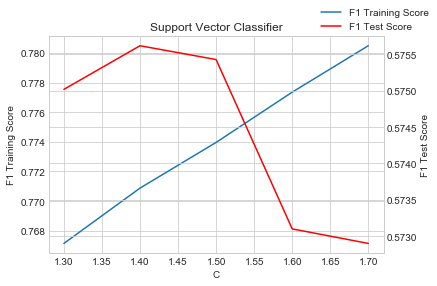

In [169]:
ax = svc_hyperParameter_C_df.plot(x="C", y="F1 Training Score", legend=False)
plt.ylabel("F1 Training Score")
ax2 = ax.twinx()
svc_hyperParameter_C_df.plot(x="C", y="F1 Test Score", ax=ax2, legend=False, color="r")
plt.ylabel("F1 Test Score")
ax.figure.legend()

plt.title("Support Vector Classifier")
plt.show()

# Choose final full model via score:

### logistic regression

In [170]:
text_logr = Pipeline([('vect',CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced",
                                              C = 1.5))])

In [171]:
text_logr = text_logr.fit(X_train, y_train)

In [172]:
y_train_pred_logr = cross_val_predict(text_logr, X_train, y_train, cv=3)

In [173]:
confusion_matrix(y_train,y_train_pred_logr)

array([[20825,  6339],
       [ 3694,  6449]])

In [174]:
accuracy_precision_recall_F1(y_train, y_train_pred_logr)

Accuracy Score = 0.73107
Precision Score = 0.5043
Recall Score = 0.63581
F1 Score = 0.56247


In [175]:
y_test_pred_logr = text_logr.predict(X_test)

In [176]:
confusion_matrix(y_test,y_test_pred_logr)

array([[10348,  3032],
       [ 1707,  3289]])

In [177]:
accuracy_precision_recall_F1(y_test,y_test_pred_logr)

Accuracy Score = 0.74211
Precision Score = 0.52033
Recall Score = 0.65833
F1 Score = 0.58125


In [178]:
# get predict probability 

In [179]:
y_test_pred_proba_logr = text_logr.fit(X_train, y_train).predict_proba(X_test)
y_test_pred_proba_logr = y_test_pred_proba_logr[:, 1]

In [180]:
fpr_test_logr, tpr_test_logr, thresholds_test_logr = roc_curve(y_test,
                                                               y_test_pred_proba_logr)

In [181]:
precision_test_logr, recall_test_logr, threshold_test_logr = precision_recall_curve(y_test,
                                                                  y_test_pred_proba_logr)

In [182]:
print("Linear Regression Test AUC = "+str(round(roc_auc_score(y_test,
                                           y_test_pred_proba_logr),5)))

Linear Regression Test AUC = 0.78911


### support vector classifier - linear

In [183]:
text_svc = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('svc', LinearSVC(loss='hinge', 
                                          class_weight="balanced",
                                         C = 1.5))])

In [184]:
text_svc = text_svc.fit(X_train, y_train)

In [185]:
y_train_pred_svc = cross_val_predict(text_svc, X_train, y_train, cv=3)

In [186]:
confusion_matrix(y_train,y_train_pred_svc)

array([[20913,  6251],
       [ 3948,  6195]])

In [187]:
accuracy_precision_recall_F1(y_train, y_train_pred_svc)

Accuracy Score = 0.72662
Precision Score = 0.49775
Recall Score = 0.61077
F1 Score = 0.5485


In [188]:
y_test_pred_svc = text_svc.predict(X_test)

In [189]:
confusion_matrix(y_test,y_test_pred_svc)

array([[10434,  2946],
       [ 1788,  3208]])

In [190]:
accuracy_precision_recall_F1(y_test,y_test_pred_svc)

Accuracy Score = 0.74238
Precision Score = 0.52129
Recall Score = 0.64211
F1 Score = 0.57543


In [ ]:
from sklearn.svm import SVC

In [ ]:
'''
text_svc_probability = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('svc', SVC(kernel = "linear",
                                 class_weight="balanced",
                                 C=1.5,
                                 probability=True
                     ))])
                     '''

In [ ]:
text_svc_probability = text_svc_probability.fit(X_train, y_train)

In [ ]:
y_test_pred_proba_svc = text_svc_probability.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_test_pred_proba_svc)

In [ ]:
fpr_test_svc, tpr_test_svc, thresholds_test_svc = roc_curve(y_test,
                                                               y_test_pred_proba_svc)

In [ ]:
precision_test_svc, recall_test_svc, threshold_test_svc = precision_recall_curve(y_test,
                                                                  y_test_pred_proba_svc)

In [ ]:
print("Linear Regression Test AUC = "+str(round(roc_auc_score(y_test,
                                           y_test_pred_proba_svc),5)))

In [ ]:
tpr_test_logr.shape

In [ ]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_test_svc,tpr_test_svc,color="darkred",linewidth=2,label="Support Vector Classifier - Test")
plt.plot(fpr_test_logr,tpr_test_logr,color="midnightblue",linewidth=2,label="Logistic Regession - Test")

plt.legend(loc="lower right")
plt.show()

# Filtered Words

In [191]:
from textblob import TextBlob

In [192]:
forum['postText_tb'] = forum['postText'].apply(lambda row: TextBlob(row))

### direct filter

In [193]:
#Trump
list_post_trump = []
list_post_trump.append(forum['postText_tb'].apply(lambda row: row.word_counts['trump']))
forum['postText_trump'] = list_post_trump[0]

forum_pt_trump = forum[(forum['postText_trump'] > 0)]


#Obama
list_post_obama = []
list_post_obama.append(forum['postText_tb'].apply(lambda row: row.word_counts['obama']))
forum['postText_obama'] = list_post_obama[0]

forum_pt_obama = forum[(forum['postText_obama'] > 0)]

In [194]:
forum_model_trump = forum_pt_trump[['postText','sLeftRight']]
forum_model_trump = forum_model_trump[(forum_model_trump['sLeftRight'] == 'Conservative') | (forum_model_trump['sLeftRight'] == 'Liberal')]
forum_model_trump['sLeftRight'] = np.where(forum_model_trump['sLeftRight'] == 'Conservative', 0, 1)

forum_model_obama = forum_pt_obama[['postText','sLeftRight']]
forum_model_obama = forum_model_obama[(forum_model_obama['sLeftRight'] == 'Conservative') | (forum_model_obama['sLeftRight'] == 'Liberal')]
forum_model_obama['sLeftRight'] = np.where(forum_model_obama['sLeftRight'] == 'Conservative', 0, 1)

In [265]:
forum_model_trump.shape

(7098, 2)

In [266]:
forum_model_trump['sLeftRight'].value_counts()

0    5787
1    1311
Name: sLeftRight, dtype: int64

In [267]:
forum_model_obama.shape

(4018, 2)

In [268]:
forum_model_obama['sLeftRight'].value_counts()

0    3552
1     466
Name: sLeftRight, dtype: int64

### newsapi filter

In [ ]:
#via newsapi.com

In [195]:
from newsapi import NewsApiClient

In [196]:
newsapi = NewsApiClient(api_key='a3480db49762474aa3fb817a27c509b6')

In [197]:
def get_top_n_words(corpus, n=50):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [198]:
def most_freq_news_terms(term, top_terms=50):
    term_articles = newsapi.get_everything(q=term,
                                    from_param='2018-06-11',
                                    to='2018-07-10',
                                    language='en',
                                    sort_by='relevancy',
                                    page_size=100,
                                    page=1)
        
    articleList = []
    for article_title in term_articles['articles']:
        if article_title['description'] is not None:
            articleList.append(article_title['description'])

    return get_top_n_words(articleList,n=top_terms)

In [199]:
def search_most_freq_terms(search_list, top_terms):
    final_list = []
    for search_term in search_list:
        term_list =  most_freq_news_terms(search_term, top_terms)
        final_list = final_list + term_list
    return (final_list)

In [334]:
search_list = ['barack obama','donald trump','hilary clinton', 'robert mueller','fbi investigation', 'fake news', 'foreign policy', 'bernie sanders', 'health care', '2016 election','charlottesville riots']

termlist_full = [x[0] for x in search_most_freq_terms(search_list, 30)]

In [335]:
print(termlist_full)

['obama', 'barack', 'president', 'school', 'trump', 'elementary', 'richmond', 'general', 'virginia', 'new', 'confederate', 'capital', 'venture', 'public', 'post', 'visited', 'donald', 'silicon', 'valley', 'firm', 'washington', 'prominent', 'named', 'fu', 'white', 'house', 'stuart', 'leader', 'photo', 'black', 'trump', 'donald', 'president', 'images', 'know', 'meme', 'com', 'north', 'korea', 'states', 'watch', 'fake', 'news', 'truth', 'says', 'order', 'singapore', 'hard', 'kim', 'twitter', 'new', 'big', 'funny', 'people', 'week', 'time', 'nuclear', 'post', 'york', 'just', 'trump', 'clinton', 'hilary', 'president', 'donald', 'party', 'justice', 'election', 'vote', 'didn', 'news', 'saelune', 'people', 'voted', 'video', 'breakfastman', 'media', 'way', 'children', 'investigation', 'supreme', 'court', 'said', 'department', 'gaming', 'prosecutor', 'social', 'county', 'fbi', 'series', 'mueller', 'robert', 'special', 'counsel', 'trump', 'president', 'investigation', 'donald', 'russia', 'probe',

In [318]:
forum_p = forum.copy()

for term in termlist_full:
    forum_p[term] = forum_p['postText'].apply(lambda row: row.count(term))

forum_p['full_sum'] = forum_p.sum(axis=1)

forum_p = forum_p[(forum_p['full_sum'] > 3)]
forum_p = forum_p[['postText','sLeftRight']]
forum_p = forum_p[(forum_p['sLeftRight'] == 'Conservative') | (forum_p['sLeftRight'] == 'Liberal')]
forum_p['sLeftRight'] = np.where(forum_p['sLeftRight'] == 'Conservative', 0, 1)
forum_p = forum_p.reset_index(drop=True)

In [319]:
forum_p.shape

(30532, 2)

In [320]:
forum_p['sLeftRight'].value_counts()

0    25646
1     4886
Name: sLeftRight, dtype: int64

In [285]:
search_list_trump = ['trump']
search_list_obama = ['obama']

termlist_trump = [x[0] for x in search_most_freq_terms(search_list_trump, 50)]
termlist_obama = [x[0] for x in search_most_freq_terms(search_list_obama, 50)]


In [286]:
print(termlist_trump)

['trump', 'donald', 'president', 'foundation', 'new', 'illegal', 'ivanka', 'york', 'conduct', 'general', 'attorney', 'lawsuit', 'jr', 'baby', 'underwood', 'news', 'eric', 'sues', 'family', 'said', 'times', 'video', 'ny', 'children', '25', 'filed', 'barbara', 'media', 'niro', 'tweeted', 'independence', 'decade', 'directors', 'did', 'people', 'latest', 'washington', 'post', 'london', 'night', 'melania', 'military', 'themed', 'day', 'book', 'border', 'left', '11', 'liberals', 'state']


In [287]:
print(termlist_obama)

['obama', 'president', 'barack', 'trump', 'administration', 'new', 'washington', 'did', 'post', 'donald', 'house', 'meet', 'white', 'democratic', 'border', 'said', 'people', 'york', 'year', 'children', 'russian', 'putin', 'clinton', 'party', 'policy', 'immigration', 'american', 'public', 'crimea', 'africa', 'week', 'thursday', 'fundraiser', 'msnbc', 'saying', 'times', 'office', 'private', 'world', 'say', 'talk', 'years', 'virtually', 'families', 'vote', 'child', 'summer', 'presidents', 'hillary', 'south']


In [288]:
forum_p_trump = forum.copy()

for term in termlist_trump:
    forum_p_trump[term] = forum_p_trump['postText'].apply(lambda row: row.count(term))

forum_p_trump['full_sum'] = forum_p_trump.sum(axis=1)

forum_p_trump = forum_p_trump[(forum_p_trump['full_sum'] > 1)]
forum_p_trump = forum_p_trump[['postText','sLeftRight']]
forum_p_trump = forum_p_trump[(forum_p_trump['sLeftRight'] == 'Conservative') | (forum_p_trump['sLeftRight'] == 'Liberal')]
forum_p_trump['sLeftRight'] = np.where(forum_p_trump['sLeftRight'] == 'Conservative', 0, 1)
forum_p_trump = forum_p_trump.reset_index(drop=True)

In [289]:
forum_p_trump.shape

(23207, 2)

In [290]:
forum_p_trump['sLeftRight'].value_counts()

0    19548
1     3659
Name: sLeftRight, dtype: int64

In [291]:
forum_p_obama = forum.copy()

for term in termlist_obama:
    forum_p_obama[term] = forum_p_obama['postText'].apply(lambda row: row.count(term))

forum_p_obama['full_sum'] = forum_p_obama.sum(axis=1)

forum_p_obama = forum_p_obama[(forum_p_obama['full_sum'] > 1)]
forum_p_obama = forum_p_obama[['postText','sLeftRight']]
forum_p_obama = forum_p_obama[(forum_p_obama['sLeftRight'] == 'Conservative') | (forum_p_obama['sLeftRight'] == 'Liberal')]
forum_p_obama['sLeftRight'] = np.where(forum_p_obama['sLeftRight'] == 'Conservative', 0, 1)
forum_p_obama = forum_p_obama.reset_index(drop=True)

In [292]:
forum_p_obama.shape

(20506, 2)

In [293]:
forum_p_obama['sLeftRight'].value_counts()

0    16845
1     3661
Name: sLeftRight, dtype: int64

In [321]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(forum_p['postText'], 
                                                    forum_p['sLeftRight'], 
                                                    stratify=forum_p['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [295]:
X_train_p_trump, X_test_p_trump, y_train_p_trump, y_test_p_trump = train_test_split(forum_p_trump['postText'], 
                                                    forum_p_trump['sLeftRight'], 
                                                    stratify=forum_p_trump['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [296]:
X_train_p_obama, X_test_p_obama, y_train_p_obama, y_test_p_obama = train_test_split(forum_p_obama['postText'], 
                                                    forum_p_obama['sLeftRight'], 
                                                    stratify=forum_p_obama['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [297]:
X_train_trump, X_test_trump, y_train_trump, y_test_trump = train_test_split(forum_model_trump['postText'], 
                                                    forum_model_trump['sLeftRight'], 
                                                    stratify=forum_model_trump['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [298]:
X_train_obama, X_test_obama, y_train_obama, y_test_obama = train_test_split(forum_model_obama['postText'], 
                                                    forum_model_obama['sLeftRight'], 
                                                    stratify=forum_model_obama['sLeftRight'],
                                                    test_size=0.33,
                                                    random_state=42)

In [322]:
text_logr_p = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

text_logr_p_trump = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

text_logr_p_obama = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])


text_logr_trump = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

text_logr_obama = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                    ('log', LogisticRegression(class_weight = "balanced"))])

In [323]:
text_logr_p = text_logr_p.fit(X_train_p, y_train_p)

text_logr_p_trump = text_logr_p_trump.fit(X_train_p_trump, y_train_p_trump)

text_logr_p_obama = text_logr_p_obama.fit(X_train_p_obama, y_train_p_obama)

text_logr_trump = text_logr_trump.fit(X_train_trump, y_train_trump)

text_logr_obama = text_logr_obama.fit(X_train_obama, y_train_obama)

In [324]:
y_train_pred_logr_p = cross_val_predict(text_logr_p, X_train_p, y_train_p, cv=3)

y_train_pred_logr_p_trump = cross_val_predict(text_logr_p_trump, X_train_p_trump, y_train_p_trump, cv=3)

y_train_pred_logr_p_obama = cross_val_predict(text_logr_p_obama, X_train_p_obama, y_train_p_obama, cv=3)

y_train_pred_logr_trump = cross_val_predict(text_logr_trump, X_train_trump, y_train_trump, cv=3)

y_train_pred_logr_obama = cross_val_predict(text_logr_obama, X_train_obama, y_train_obama, cv=3)

In [325]:
confusion_matrix(y_train_p,y_train_pred_logr_p)

array([[14332,  2850],
       [ 1120,  2154]])

In [303]:
confusion_matrix(y_train_p_trump,y_train_pred_logr_p_trump)

array([[11069,  2028],
       [  822,  1629]])

In [304]:
confusion_matrix(y_train_p_obama,y_train_pred_logr_p_obama)

array([[9319, 1967],
       [ 829, 1624]])

In [305]:
confusion_matrix(y_train_trump,y_train_pred_logr_trump)

array([[3379,  498],
       [ 326,  552]])

In [306]:
confusion_matrix(y_train_obama,y_train_pred_logr_obama)

array([[2236,  144],
       [ 151,  161]])

In [326]:
accuracy_precision_recall_F1(y_train_p, y_train_pred_logr_p)

Accuracy Score = 0.80592
Precision Score = 0.43046
Recall Score = 0.65791
F1 Score = 0.52042


In [308]:
accuracy_precision_recall_F1(y_train_p_trump, y_train_pred_logr_p_trump)

Accuracy Score = 0.8167
Precision Score = 0.44545
Recall Score = 0.66463
F1 Score = 0.5334


In [309]:
accuracy_precision_recall_F1(y_train_p_obama, y_train_pred_logr_p_obama)

Accuracy Score = 0.79649
Precision Score = 0.45224
Recall Score = 0.66205
F1 Score = 0.53739


In [310]:
accuracy_precision_recall_F1(y_train_trump, y_train_pred_logr_trump)

Accuracy Score = 0.82671
Precision Score = 0.52571
Recall Score = 0.6287
F1 Score = 0.57261


In [311]:
accuracy_precision_recall_F1(y_train_obama, y_train_pred_logr_obama)

Accuracy Score = 0.89042
Precision Score = 0.52787
Recall Score = 0.51603
F1 Score = 0.52188


In [327]:
y_scores_logr_p = cross_val_predict(text_logr_p,
                                  X_train_p,
                                  y_train_p,
                                  cv=3,
                                  method="decision_function")

y_scores_logr_p_trump = cross_val_predict(text_logr_p_trump,
                                  X_train_p_trump,
                                  y_train_p_trump,
                                  cv=3,
                                  method="decision_function")

y_scores_logr_p_obama = cross_val_predict(text_logr_p_obama,
                                  X_train_p_obama,
                                  y_train_p_obama,
                                  cv=3,
                                  method="decision_function")


y_scores_logr_trump = cross_val_predict(text_logr_trump,
                                  X_train_trump,
                                  y_train_trump,
                                  cv=3,
                                  method="decision_function")

y_scores_logr_obama = cross_val_predict(text_logr_obama,
                                  X_train_obama,
                                  y_train_obama,
                                  cv=3,
                                  method="decision_function")

In [328]:
precision_logr_p, recall_logr_p, threshold_logr_p = precision_recall_curve(y_train_p,
                                                                     y_scores_logr_p)

precision_logr_p_trump, recall_logr_p_trump, threshold_logr_p_trump = precision_recall_curve(y_train_p_trump,
                                                                     y_scores_logr_p_trump)

precision_logr_p_obama, recall_logr_p_obama, threshold_logr_p_obama = precision_recall_curve(y_train_p_obama,
                                                                     y_scores_logr_p_obama)

precision_logr_trump, recall_logr_trump, threshold_logr_trump = precision_recall_curve(y_train_trump,
                                                                     y_scores_logr_trump)

precision_logr_obama, recall_logr_obama, threshold_logr_obama = precision_recall_curve(y_train_obama,
                                                                     y_scores_logr_obama)

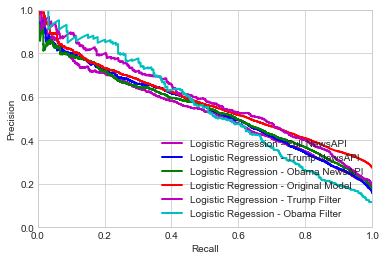

In [329]:
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot(recall_logr_p, precision_logr_p,"m",linewidth=2,label="Logistic Regression - Full NewsAPI")
plt.plot(recall_logr_p_trump, precision_logr_p_trump,"b",linewidth=2,label="Logistic Regression - Trump NewsAPI")
plt.plot(recall_logr_p_obama, precision_logr_p_obama,"g",linewidth=2,label="Logistic Regression - Obama NewsAPI")
plt.plot(recall_logr, precision_logr,"r",linewidth=2,label="Logistic Regression - Original Model")
plt.plot(recall_logr_trump, precision_logr_trump,"m",linewidth=2,label="Logistic Regression - Trump Filter")
plt.plot(recall_logr_obama, precision_logr_obama,"c",linewidth=2,label="Logistic Regession - Obama Filter")


plt.legend(loc="lower right")
plt.show()

In [330]:
fpr_logr_p, tpr_logr_p, thresholds_logr_p = roc_curve(y_train_p, y_scores_logr_p)

fpr_logr_p_trump, tpr_logr_p_trump, thresholds_logr_p_trump = roc_curve(y_train_p_trump, y_scores_logr_p_trump)

fpr_logr_p_obama, tpr_logr_p_obama, thresholds_logr_p_obama = roc_curve(y_train_p_obama, y_scores_logr_p_obama)

fpr_logr_trump, tpr_logr_trump, thresholds_logr_trump = roc_curve(y_train_trump, y_scores_logr_trump)

fpr_logr_obama, tpr_logr_obama, thresholds_logr_obama = roc_curve(y_train_obama, y_scores_logr_obama)

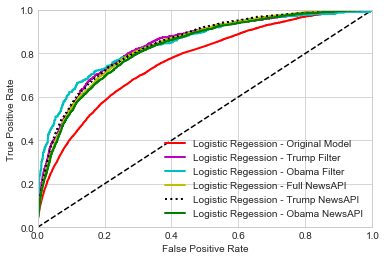

In [340]:
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_logr_swr,tpr_logr_swr,"r",linewidth=2,label="Logistic Regession - Original Model")
plt.plot(fpr_logr_trump,tpr_logr_trump,"m",linewidth=2,label="Logistic Regession - Trump Filter")
plt.plot(fpr_logr_obama,tpr_logr_obama,"c",linewidth=2,label="Logistic Regession - Obama Filter")
plt.plot(fpr_logr_p,tpr_logr_p,"y",linewidth=2,label="Logistic Regession - Full NewsAPI")
plt.plot(fpr_logr_p_trump,tpr_logr_p_trump,"k:",linewidth=2,label="Logistic Regession - Trump NewsAPI")
plt.plot(fpr_logr_p_obama,tpr_logr_p_obama,"g",linewidth=2,label="Logistic Regession - Obama NewsAPI")


plt.legend(loc="lower right")
plt.show()

In [336]:
print("Logistic Regression - Full Filter - AUC = "+str(round(roc_auc_score(y_train_p,
                                                           y_train_pred_logr_p),5)))

print("Logistic Regression - Trump NewsAPI - AUC = "+str(round(roc_auc_score(y_train_p_trump,
                                                           y_train_pred_logr_p_trump),5)))

print("Logistic Regression - Obama NewsAPI - AUC = "+str(round(roc_auc_score(y_train_p_obama,
                                                           y_train_pred_logr_p_obama),5)))

print("Logistic Regression - Trump Filter - AUC = "+str(round(roc_auc_score(y_train_trump,
                                                           y_train_pred_logr_trump),5)))

print("Logistic Regression - Obama Filter - AUC = "+str(round(roc_auc_score(y_train_obama,
                                                           y_train_pred_logr_obama),5)))

Logistic Regression - Full Filter - AUC = 0.74602
Logistic Regression - Trump NewsAPI - AUC = 0.75489
Logistic Regression - Obama NewsAPI - AUC = 0.74388
Logistic Regression - Trump Filter - AUC = 0.75013
Logistic Regression - Obama Filter - AUC = 0.72776
